                           MSE             PSNR            SSIM        
                          mean     std     mean     std    mean     std
filter_type noise_type                                                 
cnn         gaussian    0.0017  0.0013  28.5923  2.7207  0.8068  0.0664
            random      0.0012  0.0006  29.6086  2.1850  0.7847  0.0836
            salt        0.0068  0.0036  22.0541  1.7742  0.6406  0.1115
gaussian    gaussian    0.0033  0.0043  25.9407  2.5359  0.6511  0.0544
            random      0.0031  0.0044  26.6984  3.1686  0.7525  0.0708
            salt        0.0043  0.0044  24.5038  2.1521  0.5931  0.0554
lowpass     gaussian    0.0052  0.0075  24.2507  2.8211  0.5759  0.0619
            random      0.0050  0.0076  24.7213  3.2562  0.6712  0.0862
            salt        0.0061  0.0076  23.2491  2.5005  0.5210  0.0566
median      gaussian    0.0064  0.0100  23.3820  2.7383  0.5167  0.0606
            random      0.0052  0.0116  25.7951  4.1352  0.7932 

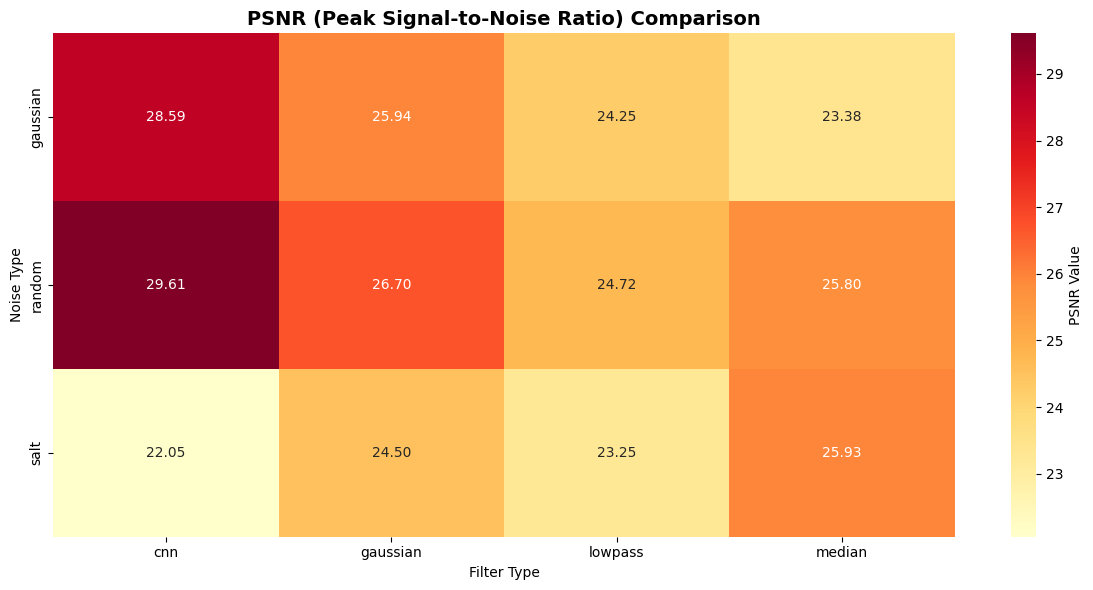

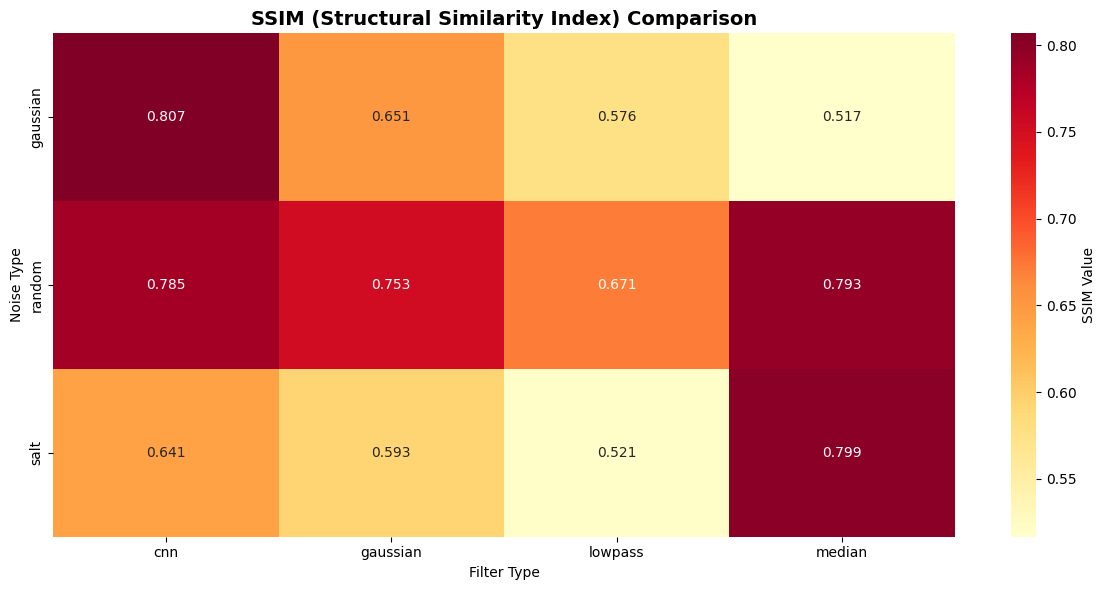

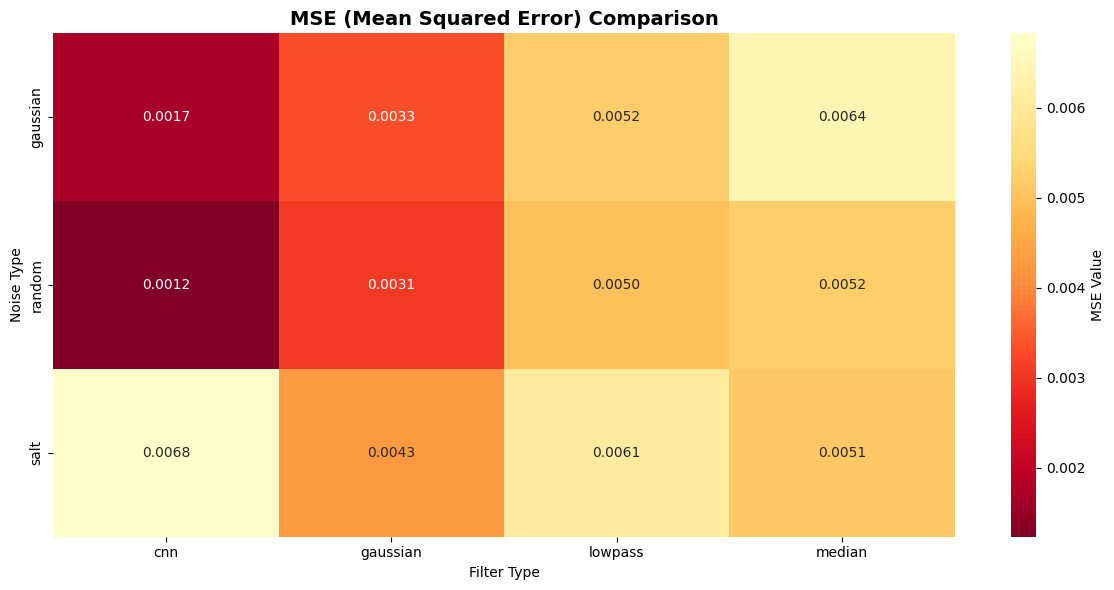


=== Best Filter Recommendations ===
random noise - Best PSNR: cnn (PSNR: 33.11)
random noise - Best SSIM: cnn (SSIM: 0.969)
random noise - Best MSE: cnn (MSE: 0.0005)

salt noise - Best PSNR: median (PSNR: 32.21)
salt noise - Best SSIM: median (SSIM: 0.915)
salt noise - Best MSE: median (MSE: 0.0006)

gaussian noise - Best PSNR: cnn (PSNR: 33.14)
gaussian noise - Best SSIM: cnn (SSIM: 0.915)
gaussian noise - Best MSE: cnn (MSE: 0.0005)

=== Overall Best Filter Analysis ===
Overall average performance by filter:
                PSNR    SSIM     MSE
filter_type                         
cnn          26.7517  0.7441  0.0033
gaussian     25.7143  0.6656  0.0036
median       25.0371  0.7030  0.0056
lowpass      24.0737  0.5894  0.0054

Overall best PSNR filter: cnn
Overall best SSIM filter: cnn
Overall best MSE filter: cnn


In [2]:
import os
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from skimage.io import imread
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_image(image_path):
    """Load image and convert to grayscale format - matching CNN test image loading method"""
    try:
        # Read image using skimage.io.imread, same as CNN test code
        image = imread(image_path)
        if len(image.shape) == 3:  # If color image, convert to grayscale
            image = np.mean(image, axis=2)
        # Convert to float32 and normalize to 0-1 range
        image = np.array(image, dtype=np.float32) / 255.0
        return image
    except Exception as e:
        # If skimage fails, try cv2
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Cannot load image: {image_path}")
        # Convert to float32 and normalize to 0-1 range
        image = np.array(image, dtype=np.float32) / 255.0
        return image

def calculate_metrics(original_img, processed_img):
    """Calculate PSNR, SSIM, MSE metrics - matching CNN test calculation method"""
    # Ensure same image dimensions
    if original_img.shape != processed_img.shape:
        from skimage.transform import resize
        processed_img = resize(processed_img, original_img.shape, anti_aliasing=True)
    
    # Ensure image values are in 0-1 range
    original_img = np.clip(original_img, 0, 1)
    processed_img = np.clip(processed_img, 0, 1)
    
    # Calculate MSE (manual calculation, consistent with skimage)
    mse_value = np.mean((original_img - processed_img) ** 2)
    
    # Calculate PSNR - using same function as CNN test
    from skimage.metrics import peak_signal_noise_ratio as compare_psnr
    psnr_value = compare_psnr(original_img, processed_img, data_range=1.0)
    
    # Calculate SSIM - using same function and parameters as CNN test
    from skimage.metrics import structural_similarity as compare_ssim
    ssim_value = compare_ssim(original_img, processed_img, 
                              data_range=original_img.max() - original_img.min())
    
    return {
        'MSE': mse_value,
        'PSNR': psnr_value,
        'SSIM': ssim_value
    }

def get_image_files(folder_path):
    """Get all image files in folder"""
    image_extensions = ['.bmp', '.jpg', '.jpeg', '.png', '.tiff']
    image_files = []
    
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_files.append(file)
    
    return sorted(image_files)

def process_folder_comparison(original_folder, processed_folder, filter_type, noise_type):
    """Compare quality metrics between original and processed images"""
    original_files = get_image_files(original_folder)
    processed_files = get_image_files(processed_folder)
    
    if not original_files or not processed_files:
        return []
    
    results = []
    
    # Process only .bmp files, pair them in order
    original_bmp = [f for f in original_files if f.lower().endswith('.bmp')]
    processed_bmp = [f for f in processed_files if f.lower().endswith('.bmp')]
    
    # Take smaller count for pairing
    min_count = min(len(original_bmp), len(processed_bmp))
    
    for i in range(min_count):
        original_file = original_bmp[i]
        processed_file = processed_bmp[i]
        
        try:
            # Load images
            original_path = os.path.join(original_folder, original_file)
            processed_path = os.path.join(processed_folder, processed_file)
            
            original_img = load_image(original_path)
            processed_img = load_image(processed_path)
            
            # Calculate metrics
            metrics = calculate_metrics(original_img, processed_img)
            
            # Record results
            result = {
                'original_filename': original_file,
                'processed_filename': processed_file,
                'filter_type': filter_type,
                'noise_type': noise_type,
                'MSE': metrics['MSE'],
                'PSNR': metrics['PSNR'],
                'SSIM': metrics['SSIM']
            }
            results.append(result)
            
        except Exception as e:
            print(f"Error processing {original_file} vs {processed_file}: {str(e)}")
    
    return results

def main():
    # Set folder paths
    original_folder = "gray"  # Original grayscale images folder
    
    # Define all processed folders
    filter_folders = {
        'median': ['mid_random', 'mid_salt', 'mid_gaussian'],
        'gaussian': ['gaus_random', 'gaus_salt', 'gaus_gaussian'],
        'lowpass': ['low_random', 'low_salt', 'low_gaussian'],
        'cnn': ['cnn_random', 'cnn_salt', 'cnn_gaussian']
    }
    
    noise_types = ['random', 'salt', 'gaussian']
    
    
    # Check if original folder exists
    if not os.path.exists(original_folder):
        print(f"Error: Original folder '{original_folder}' does not exist")
        return
    
    all_results = []
    
    # Process each filter and noise type combination
    for filter_type, folders in filter_folders.items():
        for i, folder in enumerate(folders):
            noise_type = noise_types[i]
            
            if os.path.exists(folder):
                results = process_folder_comparison(original_folder, folder, filter_type, noise_type)
                if results:
                    all_results.extend(results)
    
    # Convert results to DataFrame
    if all_results:
        df = pd.DataFrame(all_results)
        
        # Save detailed results to CSV
        df.to_csv('image_quality_results.csv', index=False, encoding='utf-8-sig')
        
        # Calculate average statistics
        summary = df.groupby(['filter_type', 'noise_type']).agg({
            'MSE': ['mean', 'std'],
            'PSNR': ['mean', 'std'],
            'SSIM': ['mean', 'std']
        }).round(4)
        
        print(summary)
        
        # Save summary statistics
        summary.to_csv('image_quality_summary.csv', encoding='utf-8-sig')
        
        # Create visualizations
        create_visualizations(df)
        
    else:
        print("No image files processed successfully")
    

def create_visualizations(df):
    """Create visualization charts"""
    try:
        # 1. PSNR comparison chart
        plt.figure(figsize=(12, 6))
        df_pivot = df.pivot_table(values='PSNR', index='noise_type', columns='filter_type', aggfunc='mean')
        sns.heatmap(df_pivot, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'PSNR Value'})
        plt.title('PSNR (Peak Signal-to-Noise Ratio) Comparison', fontsize=14, fontweight='bold')
        plt.xlabel('Filter Type')
        plt.ylabel('Noise Type')
        plt.tight_layout()
        plt.savefig('psnr_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 2. SSIM comparison chart
        plt.figure(figsize=(12, 6))
        df_pivot = df.pivot_table(values='SSIM', index='noise_type', columns='filter_type', aggfunc='mean')
        sns.heatmap(df_pivot, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'SSIM Value'})
        plt.title('SSIM (Structural Similarity Index) Comparison', fontsize=14, fontweight='bold')
        plt.xlabel('Filter Type')
        plt.ylabel('Noise Type')
        plt.tight_layout()
        plt.savefig('ssim_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 3. MSE comparison chart
        plt.figure(figsize=(12, 6))
        df_pivot = df.pivot_table(values='MSE', index='noise_type', columns='filter_type', aggfunc='mean')
        sns.heatmap(df_pivot, annot=True, fmt='.4f', cmap='YlOrRd_r', cbar_kws={'label': 'MSE Value'})
        plt.title('MSE (Mean Squared Error) Comparison', fontsize=14, fontweight='bold')
        plt.xlabel('Filter Type')
        plt.ylabel('Noise Type')
        plt.tight_layout()
        plt.savefig('mse_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 4. Best filter analysis
        print("\n=== Best Filter Recommendations ===")
        for noise in df['noise_type'].unique():
            noise_data = df[df['noise_type'] == noise]
            
            # Best PSNR
            best_psnr = noise_data.loc[noise_data['PSNR'].idxmax()]
            print(f"{noise} noise - Best PSNR: {best_psnr['filter_type']} (PSNR: {best_psnr['PSNR']:.2f})")
            
            # Best SSIM
            best_ssim = noise_data.loc[noise_data['SSIM'].idxmax()]
            print(f"{noise} noise - Best SSIM: {best_ssim['filter_type']} (SSIM: {best_ssim['SSIM']:.3f})")
            
            # Best MSE
            best_mse = noise_data.loc[noise_data['MSE'].idxmin()]
            print(f"{noise} noise - Best MSE: {best_mse['filter_type']} (MSE: {best_mse['MSE']:.4f})")
            print()
        
        # 5. Overall best filter analysis
        print("=== Overall Best Filter Analysis ===")
        overall_summary = df.groupby('filter_type').agg({
            'PSNR': 'mean',
            'SSIM': 'mean', 
            'MSE': 'mean'
        }).round(4)
        
        print("Overall average performance by filter:")
        print(overall_summary.sort_values('PSNR', ascending=False))
        
        best_overall_psnr = overall_summary['PSNR'].idxmax()
        best_overall_ssim = overall_summary['SSIM'].idxmax()
        best_overall_mse = overall_summary['MSE'].idxmin()
        
        print(f"\nOverall best PSNR filter: {best_overall_psnr}")
        print(f"Overall best SSIM filter: {best_overall_ssim}")
        print(f"Overall best MSE filter: {best_overall_mse}")
        
    except Exception as e:
        print(f"Error creating visualizations: {str(e)}")

if __name__ == "__main__":
    main()